<a href="https://colab.research.google.com/github/fravasta/Prediction-of-Taxi-fares/blob/main/prediction_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy import stats
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.svm import SVR
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [53]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data_clean.csv', sep=',')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Trip_Distance_km_log,Trip_Price_log
0,19.35000,Morning,Weekday,3.0,Low,Clear,3.560000,0.80,0.32,53.82,36.2600,3.013081,3.617920
1,47.59000,Afternoon,Weekday,1.0,High,Clear,3.500522,0.62,0.43,40.57,29.5058,3.883418,3.417917
2,36.87000,Evening,Weekend,1.0,High,Clear,2.700000,1.21,0.15,37.27,52.9000,3.634159,3.987130
3,30.33000,Evening,Weekday,4.0,Low,Clear,3.480000,0.51,0.15,116.81,36.4700,3.444576,3.623541
4,8.26455,Evening,Weekday,3.0,High,Clear,2.930000,0.63,0.32,22.64,15.6200,2.226195,2.810607


In [54]:
df = pd.read_csv("data_clean.csv", sep=",")
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data_clean.csv'

# Linear Model

In [55]:
# Create a copy to avoid modifying the original dataframe
df_model = df.copy()

# Drop the original non-log transformed columns
df_model = df_model.drop(['Trip_Distance_km', 'Trip_Price'], axis=1)

# Create dummy variables for categorical columns
categorical_columns = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']

# Create dummies and drop first category for each variable
for column in categorical_columns:
    dummies = pd.get_dummies(df_model[column], prefix=column, drop_first=True)
    df_model = pd.concat([df_model, dummies], axis=1)
    df_model = df_model.drop(column, axis=1)

df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Passenger_Count            983 non-null    float64
 1   Base_Fare                  983 non-null    float64
 2   Per_Km_Rate                983 non-null    float64
 3   Per_Minute_Rate            983 non-null    float64
 4   Trip_Duration_Minutes      983 non-null    float64
 5   Trip_Distance_km_log       983 non-null    float64
 6   Trip_Price_log             983 non-null    float64
 7   Time_of_Day_Evening        983 non-null    bool   
 8   Time_of_Day_Morning        983 non-null    bool   
 9   Time_of_Day_Night          983 non-null    bool   
 10  Day_of_Week_Weekend        983 non-null    bool   
 11  Traffic_Conditions_Low     983 non-null    bool   
 12  Traffic_Conditions_Medium  983 non-null    bool   
 13  Weather_Rain               983 non-null    bool   

## Train and analyze linear regression model

In [56]:
# Scale numerical features only
numerical_columns = ['Trip_Distance_km_log', 'Passenger_Count', 'Base_Fare',
                    'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']

scaler = StandardScaler()
df_model_scaled = df_model.copy()
df_model_scaled[numerical_columns] = scaler.fit_transform(df_model_scaled[numerical_columns])

# Separate features and target
X = df_model_scaled.drop('Trip_Price_log', axis=1)
y = df_model_scaled['Trip_Price_log']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
X_train_sm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 1 to 785
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   const                      732 non-null    float64
 1   Passenger_Count            732 non-null    float64
 2   Base_Fare                  732 non-null    float64
 3   Per_Km_Rate                732 non-null    float64
 4   Per_Minute_Rate            732 non-null    float64
 5   Trip_Duration_Minutes      732 non-null    float64
 6   Trip_Distance_km_log       732 non-null    float64
 7   Time_of_Day_Evening        732 non-null    int64  
 8   Time_of_Day_Morning        732 non-null    int64  
 9   Time_of_Day_Night          732 non-null    int64  
 10  Day_of_Week_Weekend        732 non-null    int64  
 11  Traffic_Conditions_Low     732 non-null    int64  
 12  Traffic_Conditions_Medium  732 non-null    int64  
 13  Weather_Rain               732 non-null    int64  
 14 

In [58]:
# Add constant for statsmodels
X_train_sm = sm.add_constant(X_train)

bool_cols = X_train_sm.select_dtypes(include=['bool']).columns
X_train_sm[bool_cols] = X_train_sm[bool_cols].astype(int)

# Fit the model
linear_model = sm.OLS(y_train, X_train_sm).fit()

# Print summary
print("\nModel Summary:")
print(linear_model.summary())


Model Summary:
                            OLS Regression Results                            
Dep. Variable:         Trip_Price_log   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     170.3
Date:                Mon, 27 Jan 2025   Prob (F-statistic):          1.07e-224
Time:                        14:06:43   Log-Likelihood:                -121.97
No. Observations:                 786   AIC:                             273.9
Df Residuals:                     771   BIC:                             343.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const 

In [59]:
X_train_sm = X_train_sm.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

## Outliers

In [60]:
# Get influence measures
influence = linear_model.get_influence()
# Standardized residuals
standardized_residuals = influence.resid_studentized_internal
# Leverage (hat values)
leverage = influence.hat_matrix_diag
# Cook's distance
cooks_distance = influence.cooks_distance[0]
# DFFITS
dffits = influence.dffits[0]

# Create DataFrame with all metrics
diagnostics = pd.DataFrame({
    'Standardized_Residuals': standardized_residuals,
    'Leverage': leverage,
    'Cooks_Distance': cooks_distance,
    'DFFITS': dffits
})

In [61]:
diagnostics

,Standardized_Residuals,Leverage,Cooks_Distance,DFFITS
0,-3.042814,0.023140,0.014622,-0.470855
1,-0.169903,0.032782,0.000065,-0.031260
2,-0.079035,0.010119,0.000004,-0.007986
3,1.099652,0.030947,0.002574,0.196540
4,-0.517085,0.019664,0.000358,-0.073199
...,...,...,...,...
781,1.261205,0.040441,0.004469,0.259017
782,-0.327243,0.023434,0.000171,-0.050663
783,-0.658922,0.018954,0.000559,-0.091554
784,-0.660081,0.016415,0.000485,-0.085242


In [62]:
# Soglie
threshold_std_resid = 3
threshold_leverage = 2 * (X_train_sm.shape[1] + 1) / X_train_sm.shape[0]
threshold_cooks = 4 / X_train_sm.shape[0]
threshold_dffits = 2 * np.sqrt((X_train_sm.shape[1] + 1) / X_train_sm.shape[0])

# Identificare outlier
outliers = diagnostics[
    (diagnostics['Standardized_Residuals'].abs() > threshold_std_resid) |
    (diagnostics['Leverage'] > threshold_leverage) |
    (diagnostics['Cooks_Distance'] > threshold_cooks) |
    (diagnostics['DFFITS'].abs() > threshold_dffits)
]

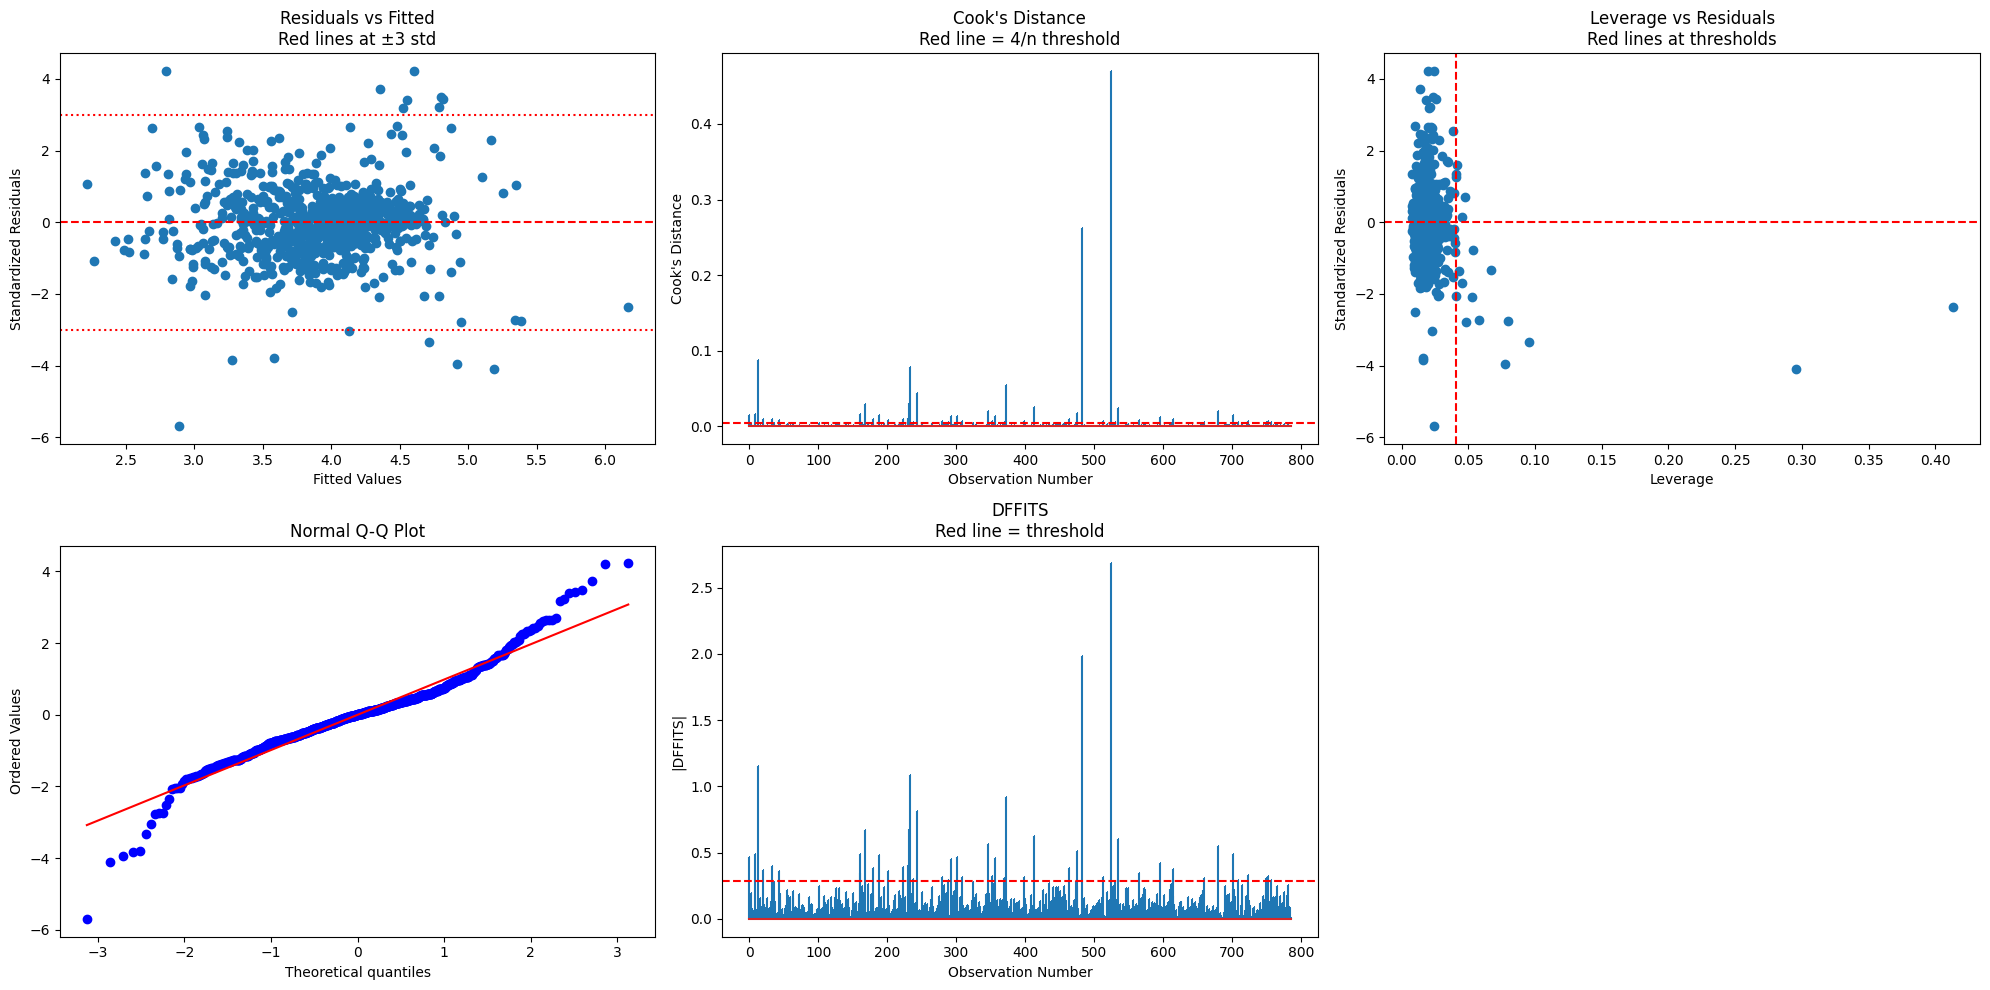

In [63]:
# Create diagnostic plots
fig = plt.figure(figsize=(20, 10))

# 1. Standardized Residuals vs Fitted Values
plt.subplot(231)
plt.scatter(linear_model.fittedvalues, standardized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=3, color='r', linestyle=':')
plt.axhline(y=-3, color='r', linestyle=':')
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
plt.title('Residuals vs Fitted\nRed lines at ±3 std')

# 2. Cook's Distance Plot
plt.subplot(232)
plt.stem(range(len(cooks_distance)), cooks_distance, markerfmt=',')
plt.axhline(y=threshold_cooks, color='r', linestyle='--')
plt.xlabel('Observation Number')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance\nRed line = 4/n threshold")

# 3. Leverage vs Standardized Residuals
plt.subplot(233)
plt.scatter(leverage, standardized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=threshold_leverage, color='r', linestyle='--')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Leverage vs Residuals\nRed lines at thresholds')

# 4. QQ Plot
plt.subplot(234)
stats.probplot(standardized_residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')

# 5. DFFITS Plot
plt.subplot(235)
plt.stem(range(len(dffits)), np.abs(dffits), markerfmt=',')
plt.axhline(y=threshold_dffits, color='r', linestyle='--')
plt.xlabel('Observation Number')
plt.ylabel('|DFFITS|')
plt.title('DFFITS\nRed line = threshold')

plt.tight_layout()
plt.show()

In [64]:
# Delete outliers
X_train_sm = X_train_sm.drop(index = outliers.index.tolist())
y_train = y_train.drop(index = outliers.index.tolist())

In [65]:
# Fit the model
linear_model = sm.OLS(y_train, X_train_sm).fit()

# Print summary
print("\nModel Summary:")
print(linear_model.summary())


Model Summary:
                            OLS Regression Results                            
Dep. Variable:         Trip_Price_log   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     347.1
Date:                Mon, 27 Jan 2025   Prob (F-statistic):          5.87e-308
Time:                        14:07:00   Log-Likelihood:                 196.24
No. Observations:                 732   AIC:                            -362.5
Df Residuals:                     717   BIC:                            -293.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const 

## Evaluate model predictions

In [67]:
# Add constant for prediction
X_test_sm = sm.add_constant(X_test)

# Make predictions
y_pred = linear_model.predict(X_test_sm)

# Converti y_pred in array numerico
y_pred = pd.to_numeric(y_pred)

# Calculate metrics
mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
r2 = linear_model.rsquared

# Calculate metrics on actual price scale
actual_prices = np.exp(y_test.astype(float))
predicted_prices = np.exp(y_pred)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")


Model Performance Metrics:
Mean Squared Error: 0.0896
Root Mean Squared Error: 0.2993
R-squared: 0.8714
Mean Absolute Percentage Error: 19.21%


## Diagnostic plots for linear regression

In [68]:
# Get residuals and fitted values
residuals = linear_model.resid
fitted_values = linear_model.fittedvalues

Text(0.5, 1.0, 'Residuals vs Fitted Values\n(Check for Linearity and Homoscedasticity)')

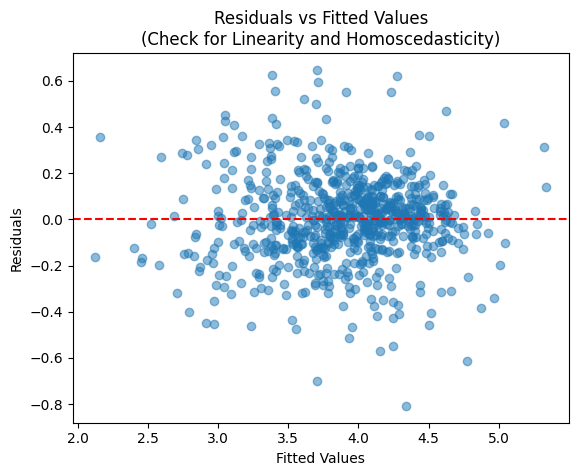

In [69]:
# 1. Residuals vs Fitted Values
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values\n(Check for Linearity and Homoscedasticity)')

Text(0.5, 1.0, 'Q-Q Plot\n(Check for Normality of Residuals)')

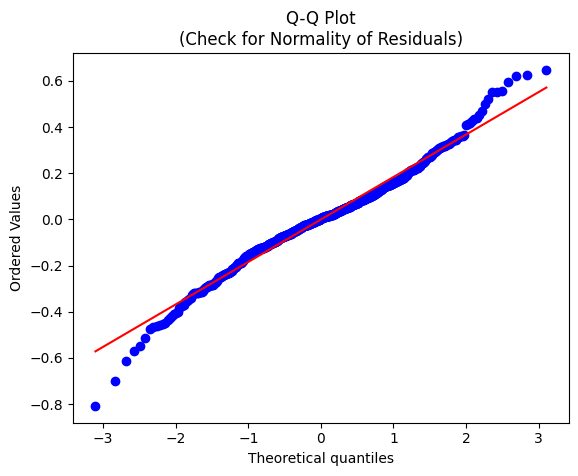

In [70]:
# 2. Q-Q Plot for Normality
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot\n(Check for Normality of Residuals)')

Text(0.5, 1.0, 'Histogram of Residuals\n(Check for Normality)')

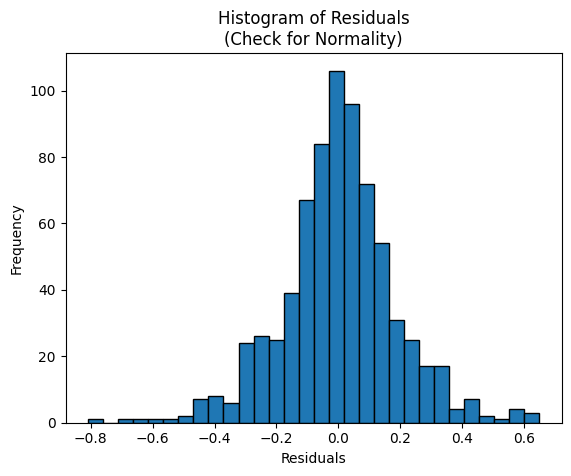

In [71]:
# 3. Residuals Histogram
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals\n(Check for Normality)')

Text(0.5, 1.0, 'Correlation Heatmap\n(Check for Multicollinearity)')

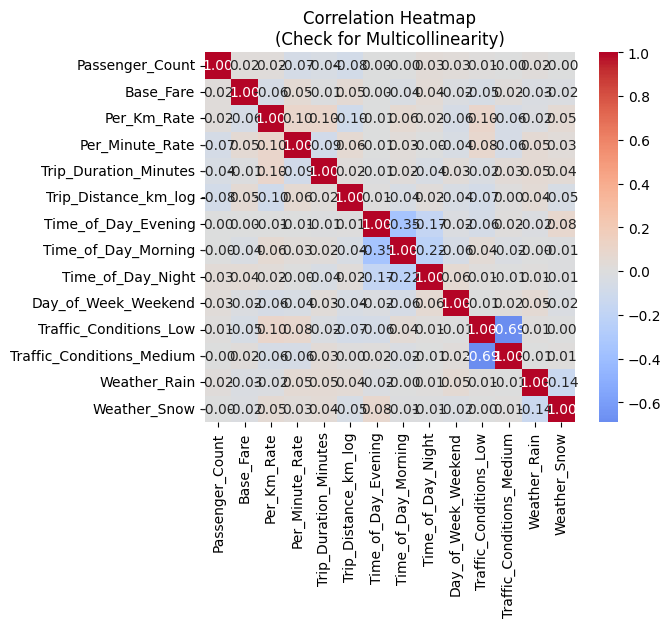

In [72]:
# 4. Correlation Heatmap
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=True, fmt='.2f', square=True)
plt.title('Correlation Heatmap\n(Check for Multicollinearity)')

# Best subset selection

In [73]:
X_train_sm.drop('const', axis=1)

n_features = X_train_sm.shape[1]

best_models = {}

for k in range(1, n_features + 1):
    best_score = -np.inf
    best_combo = None
    best_model = None

    # Get all possible combinations of k features
    for combo in combinations(range(n_features), k):
        # Get the features for this combination
        X_subset = X_train_sm.iloc[:, list(combo)]

        # Add constant
        X_subset = sm.add_constant(X_subset)

        # Fit model
        model = sm.OLS(y_train, X_subset).fit()

        # Calculate adjusted R-squared
        score = model.rsquared_adj

        if score > best_score:
            best_score = score
            best_combo = combo
            best_model = model

    # Store best model for this number of features
    best_models[k] = {
        'features': [X_train_sm.columns[i] for i in best_combo],
        'model': best_model,
        'adj_r2': best_score,
        'aic': best_model.aic,
        'bic': best_model.bic
    }

    print(f"\nBest model with {k} features:")
    print(f"Features: {best_models[k]['features']}")
    print(f"Adjusted R-squared: {best_score:.4f}")
    print(f"AIC: {best_model.aic:.4f}")
    print(f"BIC: {best_model.bic:.4f}")


Best model with 1 features:
Features: ['Trip_Distance_km_log']
Adjusted R-squared: 0.5203
AIC: 574.3426
BIC: 583.5342

Best model with 2 features:
Features: ['Per_Km_Rate', 'Trip_Distance_km_log']
Adjusted R-squared: 0.7066
AIC: 215.3832
BIC: 229.1706

Best model with 3 features:
Features: ['Per_Km_Rate', 'Trip_Duration_Minutes', 'Trip_Distance_km_log']
Adjusted R-squared: 0.8124
AIC: -111.0693
BIC: -92.6862

Best model with 4 features:
Features: ['Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Distance_km_log']
Adjusted R-squared: 0.8625
AIC: -337.1650
BIC: -314.1861

Best model with 5 features:
Features: ['Passenger_Count', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Distance_km_log']
Adjusted R-squared: 0.8688
AIC: -370.5854
BIC: -343.0107

Best model with 6 features:
Features: ['Passenger_Count', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Distance_km_log', 'Day_of_Week_Weekend']
Adjusted R-squared: 0.8693
AIC: -372.3492
B

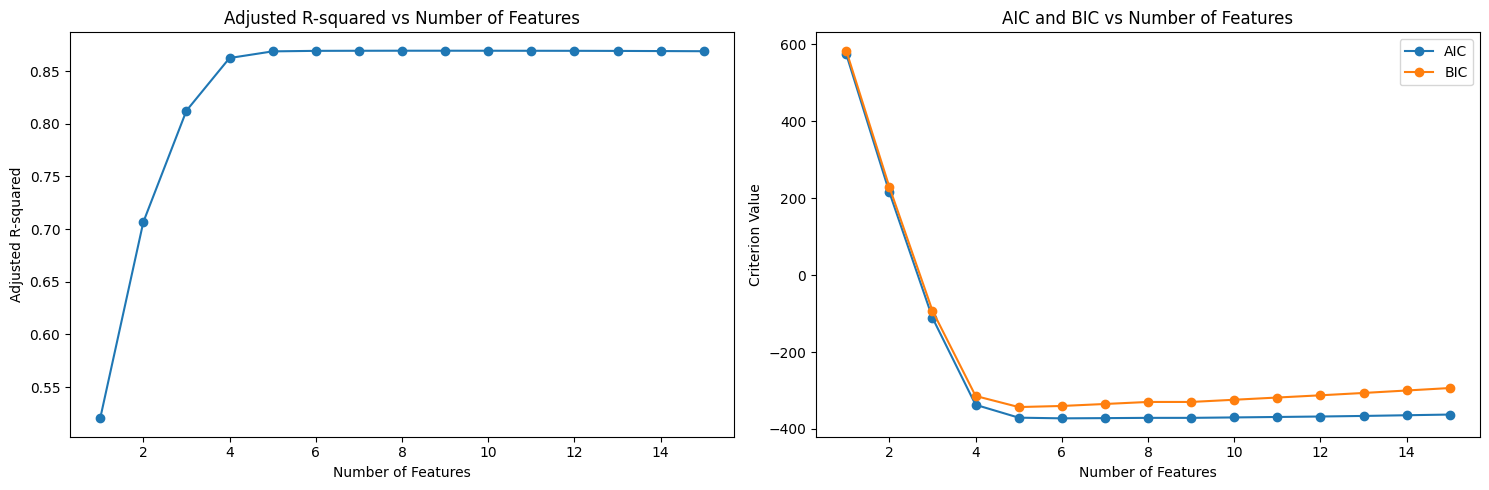

In [74]:
n_features = list(best_models.keys())
adj_r2 = [model['adj_r2'] for model in best_models.values()]
aic = [model['aic'] for model in best_models.values()]
bic = [model['bic'] for model in best_models.values()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Adjusted R-squared
ax1.plot(n_features, adj_r2, marker='o')
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('Adjusted R-squared')
ax1.set_title('Adjusted R-squared vs Number of Features')

# Plot AIC and BIC
ax2.plot(n_features, aic, marker='o', label='AIC')
ax2.plot(n_features, bic, marker='o', label='BIC')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Criterion Value')
ax2.set_title('AIC and BIC vs Number of Features')
ax2.legend()

plt.tight_layout()
plt.show()

In [75]:
# The best model
best_bic = float('inf')
best_k = None

for k, model_info in best_models.items():
    if model_info['bic'] < best_bic:
        best_bic = model_info['bic']
        best_k = k

best_k

5

In [76]:
print(best_models[5]['model'].summary())

                            OLS Regression Results                            
Dep. Variable:         Trip_Price_log   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     968.9
Date:                Mon, 27 Jan 2025   Prob (F-statistic):          2.42e-318
Time:                        14:09:38   Log-Likelihood:                 191.29
No. Observations:                 732   AIC:                            -370.6
Df Residuals:                     726   BIC:                            -343.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.90

In [77]:
r2 = best_models[5]['model'].rsquared
residuals = best_models[5]['model'].resid
mse = np.mean(residuals**2)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")


Model Performance Metrics:
Mean Squared Error: 0.0347
R-squared: 0.8697


# Support Vector Regression

In [82]:
# Create a copy to avoid modifying the original dataframe
df_model = df.copy()

# Drop the original non-log transformed columns
df_model = df_model.drop(['Trip_Distance_km', 'Trip_Price'], axis=1)

# Create dummy variables for categorical columns
categorical_columns = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']

# Create dummies and drop first category for each variable
for column in categorical_columns:
    dummies = pd.get_dummies(df_model[column], prefix=column, drop_first=True)
    df_model = pd.concat([df_model, dummies], axis=1)
    df_model = df_model.drop(column, axis=1)

df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Passenger_Count            983 non-null    float64
 1   Base_Fare                  983 non-null    float64
 2   Per_Km_Rate                983 non-null    float64
 3   Per_Minute_Rate            983 non-null    float64
 4   Trip_Duration_Minutes      983 non-null    float64
 5   Trip_Distance_km_log       983 non-null    float64
 6   Trip_Price_log             983 non-null    float64
 7   Time_of_Day_Evening        983 non-null    bool   
 8   Time_of_Day_Morning        983 non-null    bool   
 9   Time_of_Day_Night          983 non-null    bool   
 10  Day_of_Week_Weekend        983 non-null    bool   
 11  Traffic_Conditions_Low     983 non-null    bool   
 12  Traffic_Conditions_Medium  983 non-null    bool   
 13  Weather_Rain               983 non-null    bool   

In [85]:
# Scale numerical features only
numerical_columns = ['Trip_Distance_km_log', 'Passenger_Count', 'Base_Fare',
                    'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']

scaler = StandardScaler()
df_model_scaled = df_model.copy()
df_model_scaled[numerical_columns] = scaler.fit_transform(df_model_scaled[numerical_columns])

# Separate features and target
X = df_model_scaled.drop('Trip_Price_log', axis=1)
y = df_model_scaled['Trip_Price_log']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
# Train SVR model
svr = SVR(kernel='rbf')  # You can experiment with different kernels
svr.fit(X_train, y_train)

# Predictions
y_pred = svr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared Score: {r2}')

Mean Squared Error: 0.06223071319620129
R-squared Score: 0.8403198470489363


Text(0, 0.5, 'Predizioni')

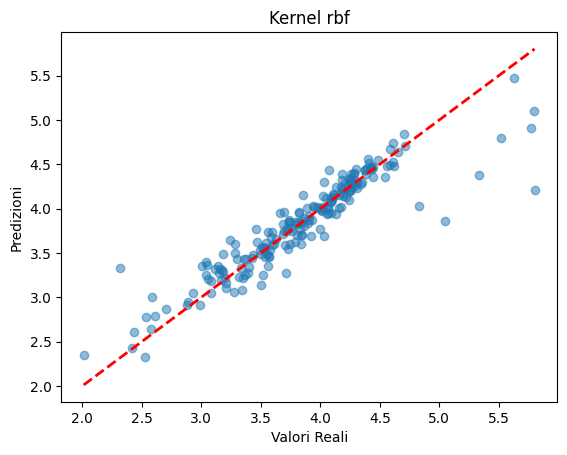

In [87]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Kernel rbf')
plt.xlabel('Valori Reali')
plt.ylabel('Predizioni')

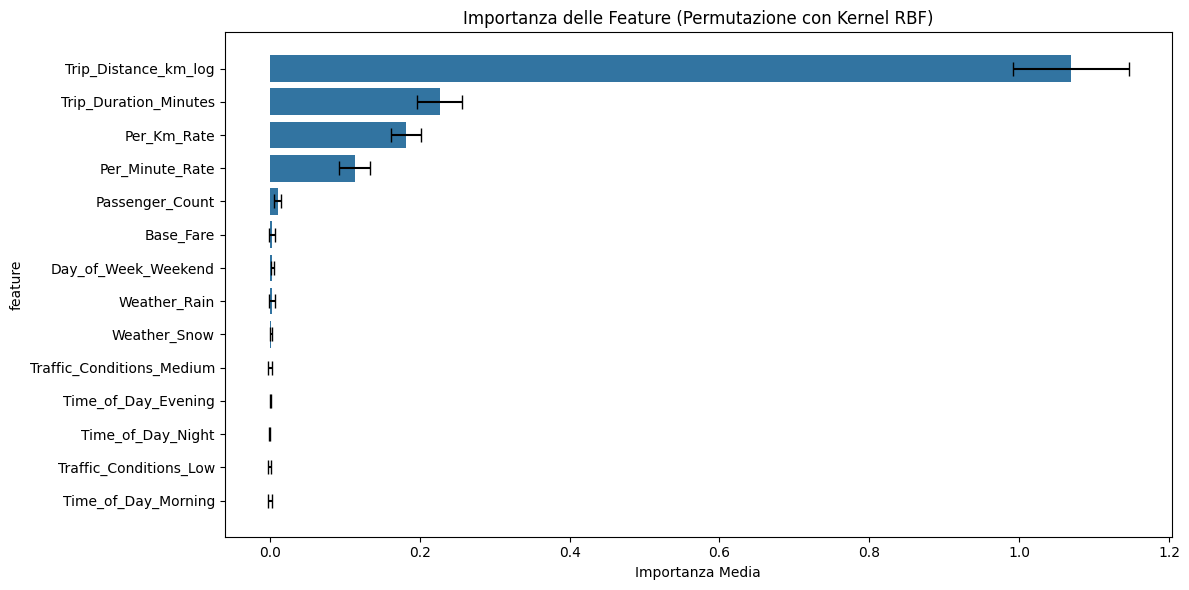

Importanza delle Feature:
                      feature  importance       std
5        Trip_Distance_km_log    1.068965  0.077420
4       Trip_Duration_Minutes    0.226377  0.029900
2                 Per_Km_Rate    0.181607  0.019965
3             Per_Minute_Rate    0.112822  0.020706
0             Passenger_Count    0.010329  0.004842
1                   Base_Fare    0.003059  0.003727
9         Day_of_Week_Weekend    0.002992  0.001915
12               Weather_Rain    0.002583  0.003545
13               Weather_Snow    0.001172  0.001486
11  Traffic_Conditions_Medium    0.000554  0.002784
6         Time_of_Day_Evening    0.000316  0.000804
8           Time_of_Day_Night   -0.000202  0.000741
10     Traffic_Conditions_Low   -0.000509  0.001729
7         Time_of_Day_Morning   -0.000517  0.002543


In [90]:
# Calcolo dell'importanza delle feature tramite permutazione
perm_importance = permutation_importance(
    svr,
    X_test,
    y_test,
    n_repeats=10,  # Numero di permutazioni
    random_state=42
)

# Creazione DataFrame con importanze
feature_names = X.columns
feature_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Ordinamento per importanza decrescente
feature_imp_df = feature_imp_df.sort_values('importance', ascending=False)

# Visualizzazione
plt.figure(figsize=(12, 6))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_imp_df
)
# Aggiungi manualmente le barre di errore
plt.errorbar(
    x=feature_imp_df['importance'],
    y=range(len(feature_imp_df)),
    xerr=feature_imp_df['std'],
    fmt='none',
    color='black',
    capsize=5
)
plt.title('Importanza delle Feature (Permutazione con Kernel RBF)')
plt.xlabel('Importanza Media')
plt.tight_layout()
plt.show()


# Stampa dei dettagli
print("Importanza delle Feature:")
print(feature_imp_df)

# Random Forest Regression

In [96]:
# Create a copy to avoid modifying the original dataframe
df_model = df.copy()

# Drop the original non-log transformed columns
df_model = df_model.drop(['Trip_Distance_km', 'Trip_Price'], axis=1)

# Create dummy variables for categorical columns
categorical_columns = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']

# Create dummies and drop first category for each variable
for column in categorical_columns:
    dummies = pd.get_dummies(df_model[column], prefix=column, drop_first=True)
    df_model = pd.concat([df_model, dummies], axis=1)
    df_model = df_model.drop(column, axis=1)

df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Passenger_Count            983 non-null    float64
 1   Base_Fare                  983 non-null    float64
 2   Per_Km_Rate                983 non-null    float64
 3   Per_Minute_Rate            983 non-null    float64
 4   Trip_Duration_Minutes      983 non-null    float64
 5   Trip_Distance_km_log       983 non-null    float64
 6   Trip_Price_log             983 non-null    float64
 7   Time_of_Day_Evening        983 non-null    bool   
 8   Time_of_Day_Morning        983 non-null    bool   
 9   Time_of_Day_Night          983 non-null    bool   
 10  Day_of_Week_Weekend        983 non-null    bool   
 11  Traffic_Conditions_Low     983 non-null    bool   
 12  Traffic_Conditions_Medium  983 non-null    bool   
 13  Weather_Rain               983 non-null    bool   

In [97]:
# Scale numerical features only
numerical_columns = ['Trip_Distance_km_log', 'Passenger_Count', 'Base_Fare',
                    'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']

scaler = StandardScaler()
df_model_scaled = df_model.copy()
df_model_scaled[numerical_columns] = scaler.fit_transform(df_model_scaled[numerical_columns])

# Separate features and target
X = df_model_scaled.drop('Trip_Price_log', axis=1)
y = df_model_scaled['Trip_Price_log']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# Initial Random Forest Model
model_rf = RandomForestRegressor(oob_score=True, random_state=42)
model_rf.fit(X_train, y_train)

# Predictions
y_pred = model_rf.predict(X_test)

# Performance Metrics
metrics = {
    'Mean Squared Error': mean_squared_error(y_test, y_pred),
    'Root Mean Squared Error': np.sqrt(mean_squared_error(y_test, y_pred)),
    'Mean Absolute Error': mean_absolute_error(y_test, y_pred),
    'Mean Absolute Percentage Error': mean_absolute_percentage_error(y_test, y_pred),
    'R-squared': r2_score(y_test, y_pred)
}

# Print Metrics
print("Model Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Model Performance Metrics:
Mean Squared Error: 0.04524673891629345
Root Mean Squared Error: 0.21271280853839866
Mean Absolute Error: 0.13890344158316312
Mean Absolute Percentage Error: 0.038789054131757435
R-squared: 0.8838996723705937


In [99]:
# Access the OOB Score
oob_score = model_rf.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

# Making predictions on the same data or new data
predictions = model_rf.predict(X)

# Evaluating the model
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.8256199227220336
Mean Squared Error: 0.015199250285246343
R-squared: 0.9553282569106759


Text(0, 0.5, 'Predizioni')

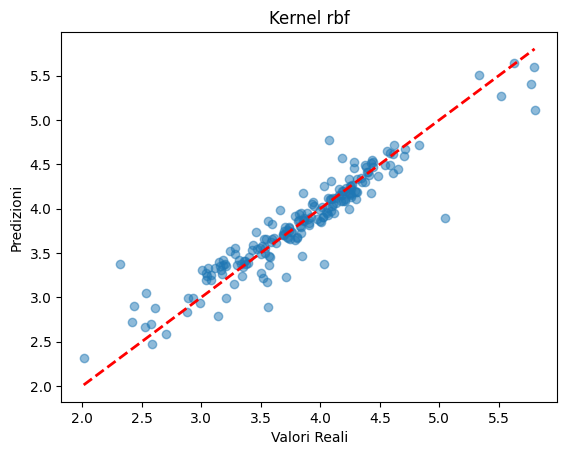

In [100]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Kernel rbf')
plt.xlabel('Valori Reali')
plt.ylabel('Predizioni')

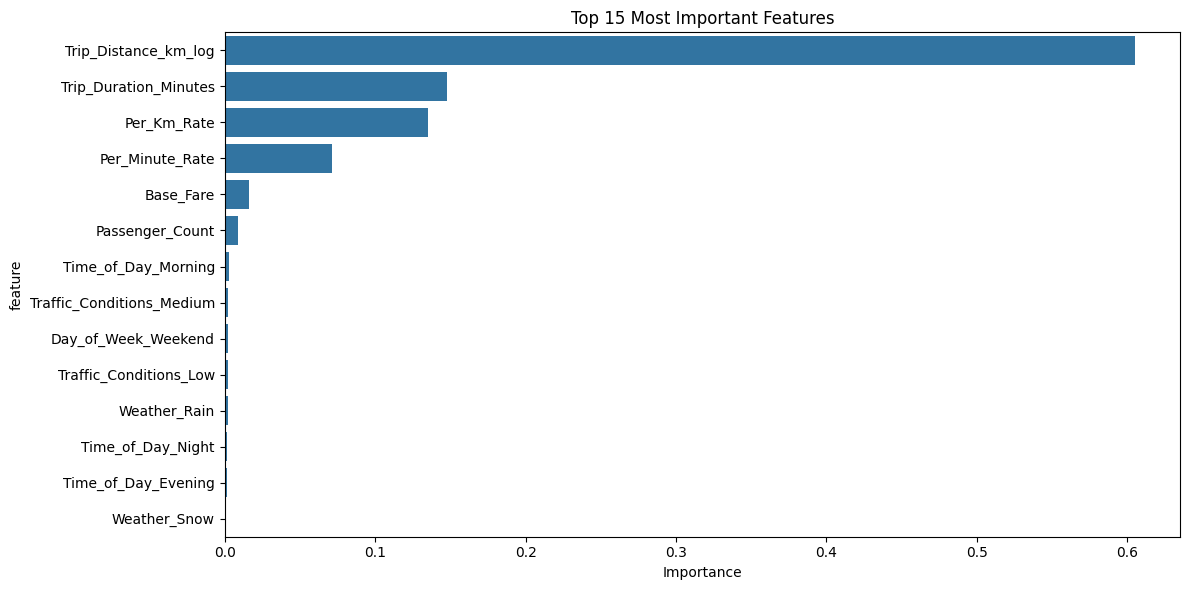

In [103]:
# Feature Importance Visualization
feature_names = X.columns
feature_importance = model_rf.feature_importances_
feature_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_imp_df.head(15))
plt.title('Top 15 Most Important Features')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

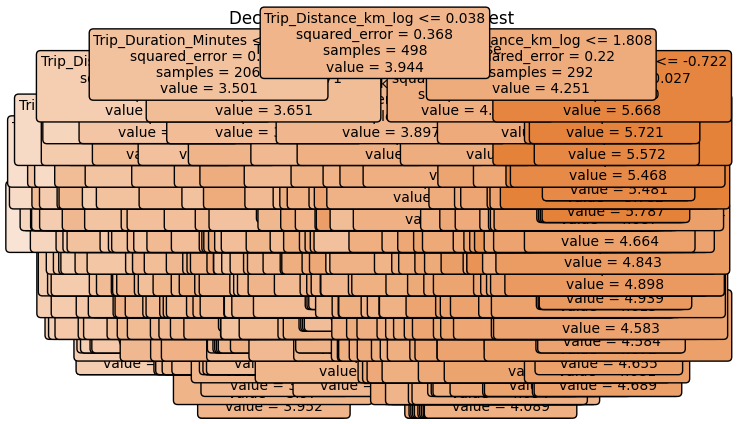

In [104]:
# Pick one tree from the forest, e.g., the first tree (index 0)
tree_to_plot = model_rf.estimators_[0]

# Plot the decision tree
plot_tree(tree_to_plot, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()

# Neural Networks

In [105]:
# Create a copy to avoid modifying the original dataframe
df_model = df.copy()

# Drop the original non-log transformed columns
df_model = df_model.drop(['Trip_Distance_km', 'Trip_Price'], axis=1)

# Create dummy variables for categorical columns
categorical_columns = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']

# Create dummies and drop first category for each variable
for column in categorical_columns:
    dummies = pd.get_dummies(df_model[column], prefix=column, drop_first=True)
    df_model = pd.concat([df_model, dummies], axis=1)
    df_model = df_model.drop(column, axis=1)

df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Passenger_Count            983 non-null    float64
 1   Base_Fare                  983 non-null    float64
 2   Per_Km_Rate                983 non-null    float64
 3   Per_Minute_Rate            983 non-null    float64
 4   Trip_Duration_Minutes      983 non-null    float64
 5   Trip_Distance_km_log       983 non-null    float64
 6   Trip_Price_log             983 non-null    float64
 7   Time_of_Day_Evening        983 non-null    bool   
 8   Time_of_Day_Morning        983 non-null    bool   
 9   Time_of_Day_Night          983 non-null    bool   
 10  Day_of_Week_Weekend        983 non-null    bool   
 11  Traffic_Conditions_Low     983 non-null    bool   
 12  Traffic_Conditions_Medium  983 non-null    bool   
 13  Weather_Rain               983 non-null    bool   

In [106]:
# Scale numerical features only
numerical_columns = ['Trip_Distance_km_log', 'Passenger_Count', 'Base_Fare',
                    'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']

scaler = StandardScaler()
df_model_scaled = df_model.copy()
df_model_scaled[numerical_columns] = scaler.fit_transform(df_model_scaled[numerical_columns])

# Separate features and target
X = df_model_scaled.drop('Trip_Price_log', axis=1)
y = df_model_scaled['Trip_Price_log']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
df_model_scaled.head()

,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Distance_km_log,Trip_Price_log,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekend,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Rain,Weather_Snow
0,0.464675,0.068663,-0.932873,0.030866,-0.284219,-0.071128,3.617920,False,True,False,False,True,False,False,False
1,-1.384620,-0.001441,-1.312259,0.470504,-0.652914,1.023433,3.417917,False,False,False,False,False,False,False,False
2,-1.384620,-0.944981,-0.068716,-0.648576,-0.744740,0.709958,3.987130,True,False,False,True,False,False,False,False
3,1.389323,-0.025630,-1.544106,-0.648576,1.468543,0.471533,3.623541,True,False,False,False,True,False,False,False
4,0.464675,-0.673890,-1.291182,0.030866,-1.151835,-1.060739,2.810607,True,False,False,False,False,False,False,False


In [107]:
def create_neural_network_model(input_shape):
    """
    Create a flexible Neural Network model for regression

    Parameters:
    -----------
    input_shape : int
        Number of input features

    Returns:
    --------
    tf.keras.Model
        Compiled neural network model
    """
    model = Sequential([
        # Input layer with dropout for regularization
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),

        # Hidden layers with increasing complexity
        Dense(32, activation='relu'),
        Dropout(0.2),

        Dense(16, activation='relu'),
        Dropout(0.1),

        # Output layer (single neuron for regression)
        Dense(1)
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

def train_and_evaluate_nn(X_train, X_test, y_train, y_test):
    """
    Train and evaluate Neural Network model

    Parameters:
    -----------
    X_train : numpy.ndarray
        Training features
    X_test : numpy.ndarray
        Testing features
    y_train : numpy.ndarray
        Training target
    y_test : numpy.ndarray
        Testing target

    Returns:
    --------
    dict
        Model performance metrics and history
    """
    # Create the model
    model = create_neural_network_model(X_train.shape[1])

    # Callbacks for training
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # Predictions
    y_pred = model.predict(X_test).flatten()

    # Performance Metrics
    metrics = {
        'Mean Squared Error': mean_squared_error(y_test, y_pred),
        'Root Mean Squared Error': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Mean Absolute Error': mean_absolute_error(y_test, y_pred),
        'Mean Absolute Percentage Error': mean_absolute_percentage_error(y_test, y_pred),
        'R-squared': r2_score(y_test, y_pred)
    }

    # Visualization of Training History
    plt.figure(figsize=(12, 4))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # MAE Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Predictions vs Actual Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title('Predictions vs Actual Values')
    plt.xlabel('Actual Trip Price Log')
    plt.ylabel('Predicted Trip Price Log')
    plt.show()

    # Print Metrics
    print("Neural Network Model Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

    return {
        'model': model,
        'metrics': metrics,
        'history': history
    }

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


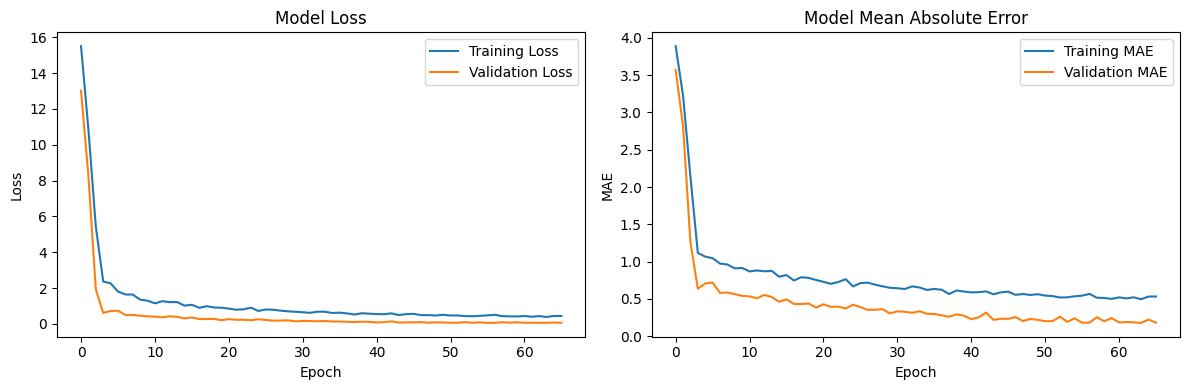

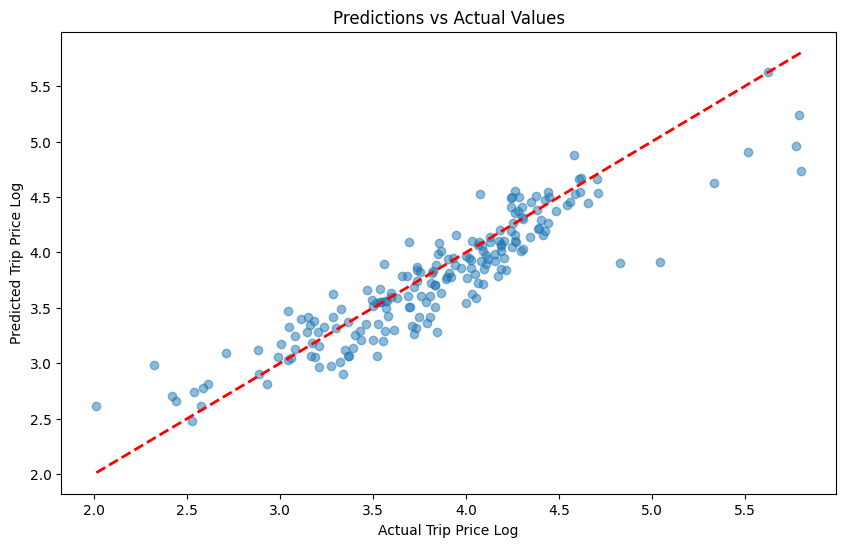

Neural Network Model Performance:
Mean Squared Error: 0.07155383006410279
Root Mean Squared Error: 0.2674954767170892
Mean Absolute Error: 0.1952437642179336
Mean Absolute Percentage Error: 0.051646097392903906
R-squared: 0.8163973070202929


In [108]:
# Run the Neural Network analysis
nn_results = train_and_evaluate_nn(
    X_train,
    X_test,
    y_train,
    y_test
)

In [111]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

train_score = mlp.score(X_train, y_train)
test_score = mlp.score(X_test, y_test)

print(f"R2 score on training set: {train_score:.3f}")
print(f"R2 score on test set: {test_score:.3f}")



R2 score on training set: 0.907
R2 score on test set: 0.881
